In [1]:
import os
import re
import numpy as np

from robosuite.models.objects import MujocoXMLObject
from robosuite.utils.mjcf_utils import xml_path_completion

from libero.libero.envs.base_object import register_object

import pathlib

from libero.libero.envs.base_object import (
    register_visual_change_object,
    register_object,
)
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, get_task_info, generate_bddl_from_task_info


[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /data/localssd/workspace/jiangwei/miniconda3/envs/libero/lib/python3.8/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Define your own objects
You may want to include more object meshes of yours in the procedural generation pipeline. One option is to include your assets and define your object directly inside the LIBERO codebase. But this can make the whole thing messy. 

Alternatively, you can define the objects inside your custom project repo folder, and define the object classes accordingly. Note that you need to import your defined object classes whenever you run your own stuff. Libero codebase cannot automatically import those that are defined outside its repo.

In the next, we provide an example, assuming you have object meses defined in `custom_assets`. In this example, we assume the generated pddl file will be saved in `custom_pddl`.

In [2]:

class CustomObjects(MujocoXMLObject):
    def __init__(self, custom_path, name, obj_name, joints=[dict(type="free", damping="0.0005")]):
        # make sure custom path is an absolute path
        assert(os.path.isabs(custom_path)), "Custom path must be an absolute path"
        # make sure the custom path is also an xml file
        assert(custom_path.endswith(".xml")), "Custom path must be an xml file"
        super().__init__(
            custom_path,
            name=name,
            joints=joints,
            obj_type="all",
            duplicate_collision_geoms=False,
        )
        self.category_name = "_".join(
            re.sub(r"([A-Z])", r" \1", self.__class__.__name__).split()
        ).lower()
        self.object_properties = {"vis_site_names": {}}

@register_object
class LiberoMug(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug", "libero_mug.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None

@register_object
class LiberoMugYellow(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug_yellow", "libero_mug_yellow.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None


### Define the scene
Now we define the scene to load the previously defined objects. For more information about the scene genration, please look at `procedural_creation_walkthrough.ipynb`. 

In [3]:
import re
from libero.libero.envs import objects
from libero.libero.utils.bddl_generation_utils import *
from libero.libero.envs.objects import OBJECTS_DICT
from libero.libero.utils.object_utils import get_affordance_regions

from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates

@register_mu(scene_type="kitchen")
class KitchenDemoScene(InitialSceneTemplates):
    def __init__(self):

        fixture_num_info = {
            "kitchen_table": 1,
            "wooden_cabinet": 1,
        }

        object_num_info = {
            "libero_mug": 2,
            "libero_mug_yellow": 1,
        }

        super().__init__(
            workspace_name="kitchen_table",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info,
        )

    def define_regions(self):
        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, -0.30],
                region_name="wooden_cabinet_init_region",
                target_name=self.workspace_name,
                region_half_len=0.01,
                yaw_rotation=(np.pi, np.pi),
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, 0.0],
                region_name="libero_mug_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[-0.1, 0.15],
                region_name="libero_mug_yellow_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )
        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(
            self.regions
        )

    @property
    def init_states(self):
        states = [
            ("On", "libero_mug_1", "kitchen_table_libero_mug_init_region"),
            ("In", "libero_mug_2", "libero_mug_1_top_side"),
            #("On", "wooden_cabinet_1", "kitchen_table_wooden_cabinet_init_region"),
        ]
        return states

In [4]:
LiberoMug().sites

['libero_mug_top_side', 'libero_mug_default_site']

Succefully generated: 1
['./custom_pddl/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl']
Encountered some failures:  []


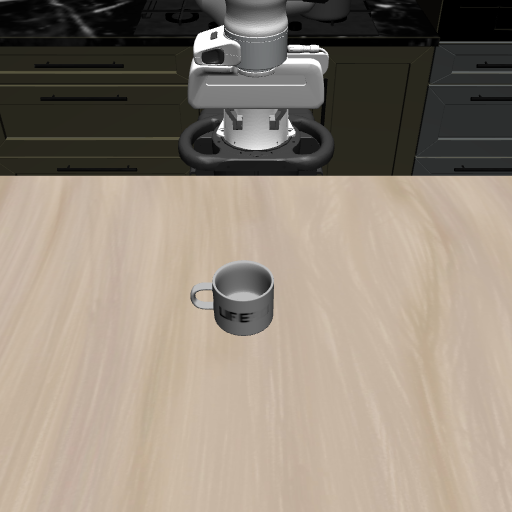

In [5]:
scene_name = "kitchen_demo_scene"
language = "libero demo behaviors"
register_task_info(language,
                   scene_name=scene_name,
                   objects_of_interest=[],
                   goal_states=[
                       ("Open", "wooden_cabinet_1_top_region"),
                       ("In", "libero_mug_yellow_1", "wooden_cabinet_1_top_region"),
                       ],
)

YOUR_BDDL_FILE_PATH = "./custom_pddl"
bddl_file_names, failures = generate_bddl_from_task_info(folder=YOUR_BDDL_FILE_PATH)
print(bddl_file_names)

print("Encountered some failures: ", failures)

# with open(bddl_file_names[0], "r") as f:
    # print(f.read())

from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision


env_args = {
    "bddl_file_name": bddl_file_names[0],
    "camera_heights": 512,
    "camera_widths": 512
}

env = OffScreenRenderEnv(**env_args)
obs = env.reset()
display(Image.fromarray(obs["agentview_image"][::-1]))

In [6]:
tenv=env.env
tenv._setup_observables()

OrderedDict([('robot0_joint_pos',
              <robosuite.utils.observables.Observable at 0x7f2092676550>),
             ('robot0_joint_pos_cos',
              <robosuite.utils.observables.Observable at 0x7f2092676610>),
             ('robot0_joint_pos_sin',
              <robosuite.utils.observables.Observable at 0x7f2092676f70>),
             ('robot0_joint_vel',
              <robosuite.utils.observables.Observable at 0x7f2092676af0>),
             ('robot0_eef_pos',
              <robosuite.utils.observables.Observable at 0x7f2092676430>),
             ('robot0_eef_quat',
              <robosuite.utils.observables.Observable at 0x7f2092676b50>),
             ('robot0_gripper_qpos',
              <robosuite.utils.observables.Observable at 0x7f20926761c0>),
             ('robot0_gripper_qvel',
              <robosuite.utils.observables.Observable at 0x7f2092676c40>),
             ('agentview_image',
              <robosuite.utils.observables.Observable at 0x7f2092676f40>),
         

In [7]:
from robosuite.utils.observables import Observable, sensor

class SiteJacpObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_jacp", self.site_jacp_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_jacp_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_jacp(self.site_name))

class SiteJacrObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_jacr", self.site_jacr_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_jacr_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_jacr(self.site_name))

class SiteXmatObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_xmat", self.site_xmat_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_xmat_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_xmat(self.site_name))

class SiteXposObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_xpos", self.site_xpos_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_xpos_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_xpos(self.site_name))

class SiteXvelpObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_xvelp", self.site_xvelp_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_xvelp_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_xvelp(self.site_name))

class SiteXvelrObservable(Observable):
    def __init__(self, site_name, parent_env, *args, **kwargs):
        self._env = parent_env
        self.site_name = site_name
        super().__init__(f"{site_name}_xvelr", self.site_xvelr_sensor, *args, **kwargs)

    @sensor(modality="object_site")
    def site_xvelr_sensor(self, obs_cache: dict):
        return np.array(self._env.sim.data.get_site_xvelr(self.site_name))

In [8]:
tenv.object_sites_dict

{'kitchen_table_wooden_cabinet_init_region': <libero.libero.envs.objects.target_zones.TargetZone at 0x7f1e935a0ca0>,
 'kitchen_table_libero_mug_init_region': <libero.libero.envs.objects.target_zones.TargetZone at 0x7f1e935a0fd0>,
 'kitchen_table_libero_mug_yellow_init_region': <libero.libero.envs.objects.target_zones.TargetZone at 0x7f1e935a0c70>,
 'wooden_cabinet_1_top_side': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a0d30>,
 'wooden_cabinet_1_top_region': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a06a0>,
 'wooden_cabinet_1_middle_region': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a0d60>,
 'wooden_cabinet_1_bottom_region': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a0670>,
 'libero_mug_1_top_side': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a05e0>,
 'libero_mug_2_top_side': <libero.libero.envs.objects.site_object.SiteObject at 0x7f1e935a0e80>}

In [9]:
tenv.add_observable(SiteXposObservable("libero_mug_1_top_side", tenv))

In [10]:
LIBERO_DUMMY_ACTION = [0.0] * 6 + [-1.0]
tenv.step(LIBERO_DUMMY_ACTION)

(OrderedDict([('robot0_joint_pos',
               array([ 5.34666967e-13, -1.61037389e-01, -4.20661527e-13, -2.44459747e+00,
                      -4.86506576e-12,  2.22675220e+00,  7.85398163e-01])),
              ('robot0_joint_pos_cos',
               array([ 1.        ,  0.98706148,  1.        , -0.76677449,  1.        ,
                      -0.60991702,  0.70710678])),
              ('robot0_joint_pos_sin',
               array([ 5.34666967e-13, -1.60342259e-01, -4.20661527e-13, -6.41916572e-01,
                      -4.86506576e-12,  7.92465287e-01,  7.07106781e-01])),
              ('robot0_joint_vel',
               array([ 8.98107449e-12,  1.68998162e-14,  4.66900265e-12, -2.09668293e-15,
                      -4.54491199e-11,  5.18732617e-15, -1.67146439e-11])),
              ('robot0_eef_pos',
               array([-2.08464661e-01, -4.67096034e-13,  1.17327948e+00])),
              ('robot0_eef_quat',
               array([ 9.99596605e-01,  2.46212834e-04, -2.84001205e-02, 